In [141]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [142]:
""" underlying map -- cant move oob or itw """
_w = 1
_g = 2
_f = 3
_k = 4
m = np.array([
    [ _f, _f, _w, _f, _f, _f, _f, _k, ],
    [ _f, _f, _w, _f, _f, _w, _f, _f, ],
    [ _f, _f, _w, _f, _f, _w, _w, _w, ],
    [ _f, _f, _w, _f, _f, _w, _f, _f, ],
    [ _f, _f, _f, _f, _f, _f, _f, _f, ],
    [ _f, _w, _w, _w, _w, _w, _w, _f, ],
    [ _f, _f, _f, _f, _w, _g, _f, _f, ],
]).T
w = m == _w
nw = m != _w
g = m == _g
ng = m != _g
f = m == _f
nf = m != _f
k = m == _k
nk = m != _k

""" states, actions """
W = 8
H = 7
K = 2
S = W*H*W*H*K
A = 5
UP, DOWN, LEFT, RIGHT, STAY = 0, 1, 2, 3, 4

""" utilities """
p_x_c = np.arange(W).reshape((W, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1))
p_y_c = np.arange(H).reshape((1, H, 1, 1, 1, 1, 1, 1, 1, 1, 1))
m_x_c = np.arange(W).reshape((1, 1, W, 1, 1, 1, 1, 1, 1, 1, 1))
m_y_c = np.arange(H).reshape((1, 1, 1, H, 1, 1, 1, 1, 1, 1, 1))
k_c   = np.arange(K).reshape((1, 1, 1, 1, K, 1, 1, 1, 1, 1, 1))
a_c   = np.arange(A).reshape((1, 1, 1, 1, 1, A, 1, 1, 1, 1, 1))
p_x_n = np.arange(W).reshape((1, 1, 1, 1, 1, 1, W, 1, 1, 1, 1))
p_y_n = np.arange(H).reshape((1, 1, 1, 1, 1, 1, 1, H, 1, 1, 1))
m_x_n = np.arange(W).reshape((1, 1, 1, 1, 1, 1, 1, 1, W, 1, 1))
m_y_n = np.arange(H).reshape((1, 1, 1, 1, 1, 1, 1, 1, 1, H, 1))
k_n   = np.arange(K).reshape((1, 1, 1, 1, 1, 1, 1, 1, 1, 1, K))

""" Probability of player movements given actions (1 if feasible) """
P_p = np.zeros((W, H, K, A, W, H, K))
P_p[p_x_c, p_y_c, k_c, UP   , p_x_n, p_y_n, k_n] = ((k_n == 1) * (k_c != -1) * k[p_x_n, p_y_n] + (k_n == k_c) * nk[p_x_n, p_y_n]) * (p_x_c == p_x_n) * (p_y_c - 1 == p_y_n) * nw[p_x_c, p_y_c] * nw[p_x_n, p_y_n]
P_p[p_x_c, p_y_c, k_c, DOWN , p_x_n, p_y_n, k_n] = ((k_n == 1) * (k_c != -1) * k[p_x_n, p_y_n] + (k_n == k_c) * nk[p_x_n, p_y_n]) * (p_x_c == p_x_n) * (p_y_c + 1 == p_y_n) * nw[p_x_c, p_y_c] * nw[p_x_n, p_y_n]
P_p[p_x_c, p_y_c, k_c, LEFT , p_x_n, p_y_n, k_n] = ((k_n == 1) * (k_c != -1) * k[p_x_n, p_y_n] + (k_n == k_c) * nk[p_x_n, p_y_n]) * (p_x_c + 1 == p_x_n) * (p_y_c == p_y_n) * nw[p_x_c, p_y_c] * nw[p_x_n, p_y_n]
P_p[p_x_c, p_y_c, k_c, RIGHT, p_x_n, p_y_n, k_n] = ((k_n == 1) * (k_c != -1) * k[p_x_n, p_y_n] + (k_n == k_c) * nk[p_x_n, p_y_n]) * (p_x_c - 1 == p_x_n) * (p_y_c == p_y_n) * nw[p_x_c, p_y_c] * nw[p_x_n, p_y_n]
P_p[p_x_c, p_y_c, k_c, STAY , p_x_n, p_y_n, k_n] = ((k_n == 1) * (k_c != -1) * k[p_x_n, p_y_n] + (k_n == k_c) * nk[p_x_n, p_y_n]) * (p_x_c == p_x_n) * (p_y_c == p_y_n)

""" Probability of minotaur movements (1 over amount of feasible actions)"""
_P_m = np.zeros((W, H, W, H, A, W, H))
m_x_n_det = m_x_c + np.sign(p_x_c - m_x_c) * (np.abs(p_x_c - m_x_c) >= np.abs(p_y_c - m_y_c))
m_y_n_det = m_y_c + np.sign(p_y_c - m_y_c) * (np.abs(p_x_c - m_x_c) < np.abs(p_y_c - m_y_c))
p_rand = 0.65
_P_m[p_x_c, p_y_c, m_x_c, m_y_c, UP   , m_x_n, m_y_n] = p_rand * (m_x_c == m_x_n) * (m_y_c - 1 == m_y_n) + (1 - p_rand) * (m_x_n == m_x_n_det) * (m_y_n == m_y_n_det)
_P_m[p_x_c, p_y_c, m_x_c, m_y_c, DOWN , m_x_n, m_y_n] = p_rand * (m_x_c == m_x_n) * (m_y_c + 1 == m_y_n) + (1 - p_rand) * (m_x_n == m_x_n_det) * (m_y_n == m_y_n_det)
_P_m[p_x_c, p_y_c, m_x_c, m_y_c, LEFT , m_x_n, m_y_n] = p_rand * (m_x_c + 1 == m_x_n) * (m_y_c == m_y_n) + (1 - p_rand) * (m_x_n == m_x_n_det) * (m_y_n == m_y_n_det)
_P_m[p_x_c, p_y_c, m_x_c, m_y_c, RIGHT, m_x_n, m_y_n] = p_rand * (m_x_c - 1 == m_x_n) * (m_y_c == m_y_n) + (1 - p_rand) * (m_x_n == m_x_n_det) * (m_y_n == m_y_n_det)
P_m = np.sum(_P_m, axis=4)
P_m = P_m / np.maximum(np.sum(P_m, axis=(4,5), keepdims=True), 1)

"""
    h)
incorporate the key into the reward function, etc
"""
""" make probability """
# P(p_t,m_t,a_t,p_t+1,m_t+1) = P_p(p_t,a_t,p_t+1) * P_m(m_t,m_t+1)
P = P_p[p_x_c, p_y_c, k_c, a_c, p_x_n, p_y_n, k_n] * P_m[p_x_c, p_y_c, m_x_c, m_y_c, m_x_n, m_y_n]
P[p_x_c, p_y_c, p_x_c, p_y_c, :, :, :, :, :, :, :] = 0
P[p_x_c, p_y_c, p_x_c, p_y_c, :, :, p_x_c, p_y_c, p_x_c, p_y_c, :] = 1

""" make reward """
R = np.zeros((W, H, W, H, K, A))
R[p_x_c, p_y_c, m_x_c, m_y_c, 0, a_c] = -1 * (0.5 > k[p_x_n, p_y_n] * (p_x_n != m_x_n) * (p_y_n != m_y_n)).reshape((W, H, W, H, 1, 1, 1, 1, 1, 1, 1)) * np.ones((1, 1, 1, 1, 1, A, 1, 1, 1, 1, 1))
R[p_x_c, p_y_c, m_x_c, m_y_c, 1, a_c] = -1 * (0.5 > g[p_x_n, p_y_n] * (p_x_n != m_x_n) * (p_y_n != m_y_n)).reshape((W, H, W, H, 1, 1, 1, 1, 1, 1, 1)) * np.ones((1, 1, 1, 1, 1, A, 1, 1, 1, 1, 1))

""" flatten to move to state space """
P = P.reshape((S, A, S))
R = R.reshape((S, A))
s0 = np.arange((W*H*W*H*K)).reshape((W, H, W, H, K))[0, 0, 5, 6, 0]

In [143]:
# let unused/inaccessible states self-loop
is_zero = (np.sum(P, axis=2) == 0)
for s, a in zip(*np.where(is_zero)):
    P[s, a, s] = 1

In [144]:
def plot_policy(policy, mk):
    plt.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
    for x in range(W):
        for y in range(H):
            s = np.ravel_multi_index((x, y, *mk), (W, H, W, H, K))
            if f[x, y]:
                if policy[s] == UP: plt.arrow(x, y, 0, -0.5, color='r', width=0.1)
                if policy[s] == DOWN: plt.arrow(x, y, 0, 0.5, color='r', width=0.1)
                if policy[s] == RIGHT: plt.arrow(x, y, -0.5, 0, color='r', width=0.1)
                if policy[s] == LEFT: plt.arrow(x, y, 0.5, 0, color='r', width=0.1)
    plt.plot(*mk[:2], 'go', markersize=20)

In [145]:
T = 20
def DP(
        T: int, # horizon
    ) -> (
        np.ndarray((T+1, S)), # value
        np.ndarray((T, S)), # policy
    ):
    value = np.zeros((T+1, S))
    policy = np.zeros((T, S), dtype=np.int32)

    for t in range(T-1,-1,-1):
        Q = R + P @ value[t+1]
        value[t] = np.max(Q, axis=1)
        policy[t] = np.argmax(Q, axis=1)
    return value, policy

def simulate_DP(
        T: int, # horizon
        policy: np.ndarray((T, S)),
    ) -> (
        bool, # did escape
        np.ndarray((W,H)), # time of every player position
        np.ndarray((W,H)), # time of every minotaur position
    ):
    s = s0
    map_p = np.zeros((W,H))
    map_m = np.zeros((W,H))
    p_x, p_y, m_x, m_y, k = np.unravel_index(s, (W, H, W, H, K))
    map_p[p_x, p_y] = 1
    map_m[m_x, m_y] = 1

    for t in range(T):
        p = P[s, policy[t, s]] # probabilities of possible next states

        s = np.random.choice(np.arange(S), p=p) # select next state
        p_x, p_y, m_x, m_y, k = np.unravel_index(s, (W, H, W, H, K))
        map_p[p_x, p_y] = t + 1
        map_m[m_x, m_y] = t + 1

    return (g[p_x, p_y] and ng[m_x, m_y] and k), map_p, map_m

def VI(
        gamma: float, # discount factor
    ) -> (
        np.ndarray((S,)), # value
        np.ndarray((S,)), # policy
    ):
    value = np.zeros((S,))
    policy = np.zeros((S,), dtype=np.int32)

    for _ in range(100):
        Q = R + gamma * P @ value
        value = np.max(Q, axis=1)
    policy = np.argmax(Q, axis=1)
    return value, policy

def simulate_VI(
        policy: np.ndarray((S,)),
        p_end: float = 0,
    ) -> (
        bool, # did escape
        np.ndarray((W,H)), # time of every player position
        np.ndarray((W,H)), # time of every minotaur position
    ):
    t = 1
    s = s0
    map_p = np.zeros((W,H))
    map_m = np.zeros((W,H))
    p_x, p_y, m_x, m_y, k = np.unravel_index(s, (W, H, W, H, K))
    map_p[p_x, p_y] = t
    map_m[m_x, m_y] = t

    while True:
        p = P[s, policy[s]] # probabilities of possible next states

        s = np.random.choice(np.arange(S), p=p) # select next state
        t += 1
        p_x, p_y, m_x, m_y, k = np.unravel_index(s, (W, H, W, H, K))
        map_p[p_x, p_y] = t
        map_m[m_x, m_y] = t

        if (p_x, p_y) == (m_x, m_y):
            break
        if g[p_x, p_y] and ng[m_x, m_y] and k:
            break
        if np.random.uniform() > p_end:
            break

    return (g[p_x, p_y] and ng[m_x, m_y] and k), map_p, map_m

if False:
    vi_value, vi_policy = VI(1 - 1/50)
    print(vi_value[s0])
    escaped, map_p, map_m = simulate_VI(vi_policy, 1 - 1/50)
    print(escaped)
    
    plt.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
    plt.imshow(map_m.T, alpha=(map_m > 0).T.astype(np.float32))
    plt.show()
    plt.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
    plt.imshow(map_p.T, alpha=(map_p > 0).T.astype(np.float32))

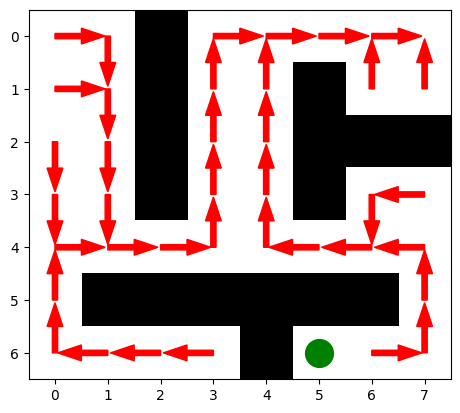

In [146]:
plot_policy(vi_policy, (5, 6, 0))

In [147]:
from typing import Callable, Any
def try_else(
        f: Callable,
        default: Any,
    ) -> Any:
    try:
        return f()
    except:
        return default

In [148]:
s = s0
n = np.ones((S, A)) # frequency, do not reset?
epsilon = 0.2
alpha = 2/3
gamma = 0.8
num_episode = 50000
r = np.zeros((num_episode,))

for i, j in zip(*np.where(k)):
    key_pos = (i, j)
for i, j in zip(*np.where(g)):
    goal_pos = (i, j)

def possible_actions(p_x, p_y):
    a = [ STAY ]
    if (0 <= p_x) and (p_x < W - 1) and (0 <= p_y) and (p_y < H):
        if nw[p_x + 1, p_y]:
            a += [ LEFT ]
    if (1 <= p_x) and (p_x < W) and (0 <= p_y) and (p_y < H):
        if nw[p_x - 1, p_y]:
            a += [ RIGHT ]
    if (0 <= p_x) and (p_x < W) and (1 <= p_y) and (p_y < H):
        if nw[p_x, p_y - 1]:
            a += [ UP ]
    if (0 <= p_x) and (p_x < W) and (0 <= p_y) and (p_y < H - 1):
        if nw[p_x, p_y + 1]:
            a += [ DOWN ]
    return a

def move(p_x, p_y, a):
    if a == UP:
        return (p_x, p_y - 1)
    elif a == DOWN:
        return (p_x, p_y + 1)
    elif a == LEFT:
        return (p_x + 1, p_y)
    elif a == RIGHT:
        return (p_x - 1, p_y)
    elif a == STAY:
        return (p_x, p_y)

def possible_moves_minotaur(m_x, m_y):
    m = []
    if (m_x + 1 < W):
        m += [ (m_x + 1, m_y) ]
    if (m_x - 1 >= 0):
        m += [ (m_x - 1, m_y) ]
    if (m_y + 1 < H):
        m += [ (m_x, m_y + 1) ]
    if (m_y - 1 >= 0):
        m += [ (m_x, m_y - 1) ]
    return m

Q = -np.random.uniform(size=(W, H, W, H, K, A))
for p_x, p_y in zip(*np.where(f)):
    Q[p_x, p_y, :, :, :, :] = -100000
    for a in possible_actions(p_x, p_y):
        p_x_next, p_y_next = move(p_x, p_y, a)
        Q[p_x, p_y, :, :, 0, a] = -1
        Q[p_x, p_y, :, :, 1, a] = -1
    Q[p_x, p_y, p_x, p_y, :, :] = -100000
Q = Q.reshape((S, A))

n = np.ones((S, A)) # frequency, do not reset?

for episode in tqdm(range(num_episode)):
    s = s0
    a = LEFT
    p_x, p_y, m_x, m_y, k_c = np.unravel_index(s, (W, H, W, H, K))
    while True:
        p_x, p_y, m_x, m_y, k_c = np.unravel_index(s, (W, H, W, H, K))

        # choose action, move to state
        pA = possible_actions(p_x, p_y)
        p_x_next, p_y_next = move(p_x, p_y, a)
        pM = possible_moves_minotaur(m_x, m_y)
        m_x_det = m_x + np.sign(p_x - m_x) * (np.abs(p_x - m_x) >= np.abs(p_y - m_y))
        m_y_det = m_y + np.sign(p_y - m_y) * (np.abs(p_x - m_x) < np.abs(p_y - m_y))
        m_x_next, m_y_next = pM[np.random.choice(range(len(pM)))]
        m_x_next, m_y_next = (m_x_det, m_y_det) if np.random.uniform() < 0.35 else (m_x_next, m_y_next)
        k_next = 1 if k[p_x_next, p_y_next] else k_c
        s_next = np.ravel_multi_index((p_x_next, p_y_next, m_x_next, m_y_next, k_next), (W, H, W, H, K))

        pA = possible_actions(p_x_next, p_y_next)
        while True:
            a_next = np.random.choice(pA) if np.random.uniform() < epsilon else np.argmax(Q[s_next])
            if a_next in pA:
                break

        # update Q
        n[s, a] += 1
        Q[s, a] = Q[s, a] +  1 / n[s, a]**alpha * (R[s, a] + gamma * np.max(Q[s_next]) - Q[s, a])

        # break conditions
        if (p_x_next, p_y_next) == (m_x_next, m_y_next):
            break
        if g[p_x_next, p_y_next] and ng[m_x_next, m_y_next] and k_next:
            print("!")
            break
        if np.random.uniform() < 1 / 50:
            break

        # go next
        a = a_next
        s = s_next

  3%|▎         | 1284/50000 [00:05<03:48, 213.00it/s]

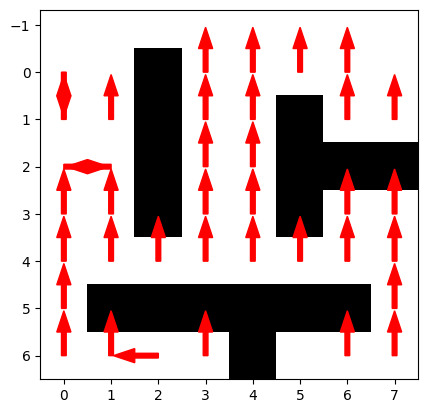

In [ ]:
# plot policy by drawing centered arrows
policy = np.argmax(Q, axis=1)
plt.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
for x in range(W):
    for y in range(H):
        s = np.ravel_multi_index((x, y, 5, 6, 0), (W, H, W, H, K))
        if f[x, y]:
            if policy[s] == UP: plt.arrow(x, y, 0, -0.5, color='r', width=0.1)
            if policy[s] == DOWN: plt.arrow(x, y, 0, 0.5, color='r', width=0.1)
            if policy[s] == RIGHT: plt.arrow(x, y, -0.5, 0, color='r', width=0.1)
            if policy[s] == LEFT: plt.arrow(x, y, 0.5, 0, color='r', width=0.1)

In [ ]:
map_m = np.zeros((W, H))
map_p = np.zeros((W, H))
s = s0
p_x, p_y, m_x, m_y, k_c = np.unravel_index(s, (W, H, W, H, K))
for t in range(200):
    # choose action, move to state
    pA = possible_actions(p_x, p_y)
    a = np.argmax(Q[s])
    assert a in pA
    p_x, p_y, m_x, m_y, k_c = np.unravel_index(s, (W, H, W, H, K))
    p_x_next, p_y_next = move(p_x, p_y, a)
    pM = possible_moves_minotaur(m_x, m_y)
    m_x_next, m_y_next = pM[np.random.choice(range(len(pM)))]
    k_next = 1 if k[p_x_next, p_y_next] else k_c
    s_next = np.ravel_multi_index((p_x_next, p_y_next, m_x_next, m_y_next, k_next), (W, H, W, H, K))

    # min
    map_p[p_x, p_y] = t + 1
    map_m[m_x, m_y] = t + 1

    # break conditions
    if (p_x_next, p_y_next) == (m_x_next, m_y_next):
        break
    if g[p_x_next, p_y_next] and ng[m_x_next, m_y_next] and k_next:
        print("!")
        break
    if np.random.uniform() < 1 / 50:
        break

    # go next
    s = s_next



plt.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
plt.imshow(map_m.T, alpha=(map_m > 0).T.astype(np.float32))
plt.show()
plt.imshow(np.ones((H, W)), alpha=w.T.astype(np.float32), cmap='gray')
plt.imshow(map_p.T, alpha=(map_p > 0).T.astype(np.float32))

AssertionError: 